нужно поискать в их коде реализацию данной идеи

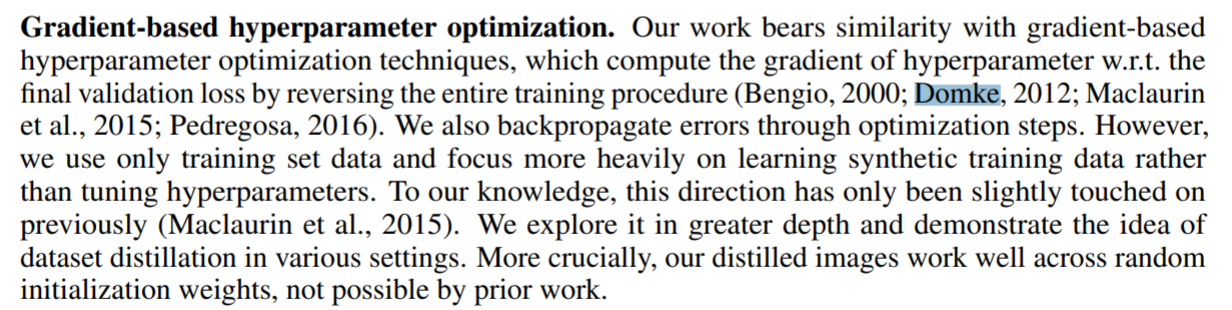

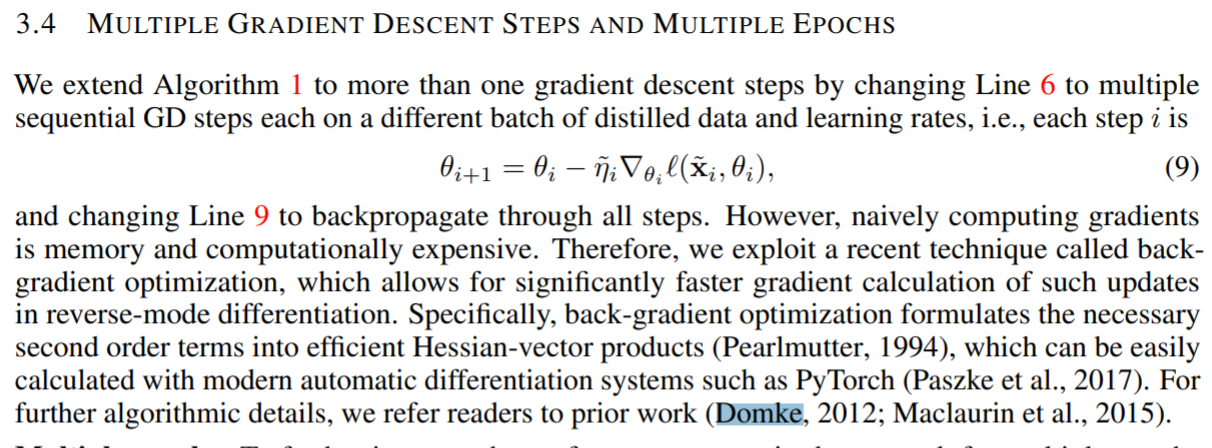

**схема приблизительно такая:**
> Есть train_distilled_image.py в нем есть forward и backward
> **В Forward**:   
>> * Каждый шаг: это шаг обучения distilled data  
>> * Для обновления параметров используется *task_loss*
>> * Идем вперед и сохраняем градиенты *gws*, параметры моделей *params*,  
>> * Последний шаг: пропустить через модель rdata (возможно это только часть реальных данных?) и получить *LL* итоговый лосс с помощью *final_objective_loss*

> **В Backward**:   
>> * Берем из **forward** *saved_for_backward* и в нем лежат: итоговый loss *L*, параметры сохраненные и градиенты (*params*, *gws*)
>> * С помощью *torch.autograd.grad(l, w)*, мы берем dw (видимо это градиент итогового Loss по данному w: Notation это подтверждает)

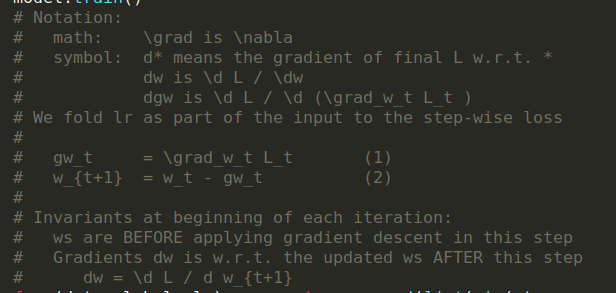

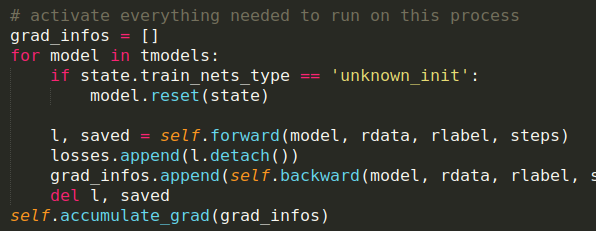

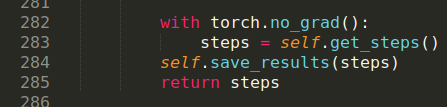

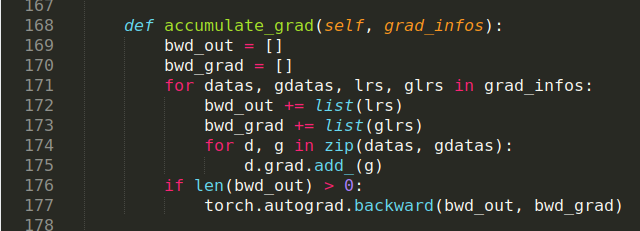

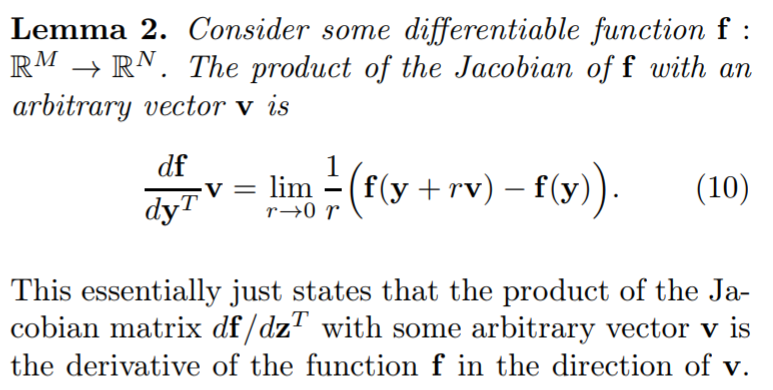

![title](../my-thoughts/1_forward.jpg)
![title](../my-thoughts/2_Backward.jpg)
![title](../my-thoughts/3_Backward.jpg)
![title](../my-thoughts/4_summary.jpg)

![title](../my-thoughts/1_forward.jpg)
![title](../my-thoughts/2_Backward.jpg)
![title](../my-thoughts/3_Backward.jpg)
![title](../my-thoughts/4_summary.jpg)

In [1]:
%load_ext autoreload
%autoreload 2

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from sklearn import datasets
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

# get data

In [2]:
# data generation
class PlaneData(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [3]:
def get_plane_dataset(type_ = 'moons', n_samples = 1500, test_size = 0.33, random_state=8):
    if type_ == 'blobs':
        X, y = dataset.smake_blobs(n_samples=n_samples, random_state=random_state)
    elif type_ == 'moons':
        X, y = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=random_state)
    elif type_ == 'circles':
        X, y = dataset.smake_circles(n_samples=n_samples, factor=5, noise=0.05, random_state=random_state)
    else:
        raise ValueError('Unsupported dataset: %s' % type_)
    X = np.array(X, dtype = np.float32)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    train_dataset = PlaneData(X_train, y_train)
    test_dataset = PlaneData(X_test, y_test)
    return train_dataset, test_dataset

In [4]:
train_dataset, test_dataset = get_plane_dataset('moons')

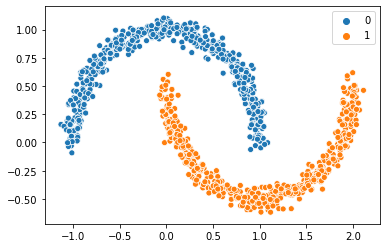

In [5]:
sns.scatterplot(train_dataset.X[:, 0], train_dataset.X[:, 1], train_dataset.y.ravel())
plt.show()

# Эксперимент

In [6]:
%load_ext autoreload
%autoreload 2
from networks import utils, get_networks
from networks.networks import MyLinearNet
from networks.networks import MyNonLinearNet
import matplotlib.pyplot as plt
import torch
import train_distilled_image
from collections import namedtuple
from basics import evaluate_steps #evaluate_models, format_stepwise_results
from sklearn.metrics import accuracy_score

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


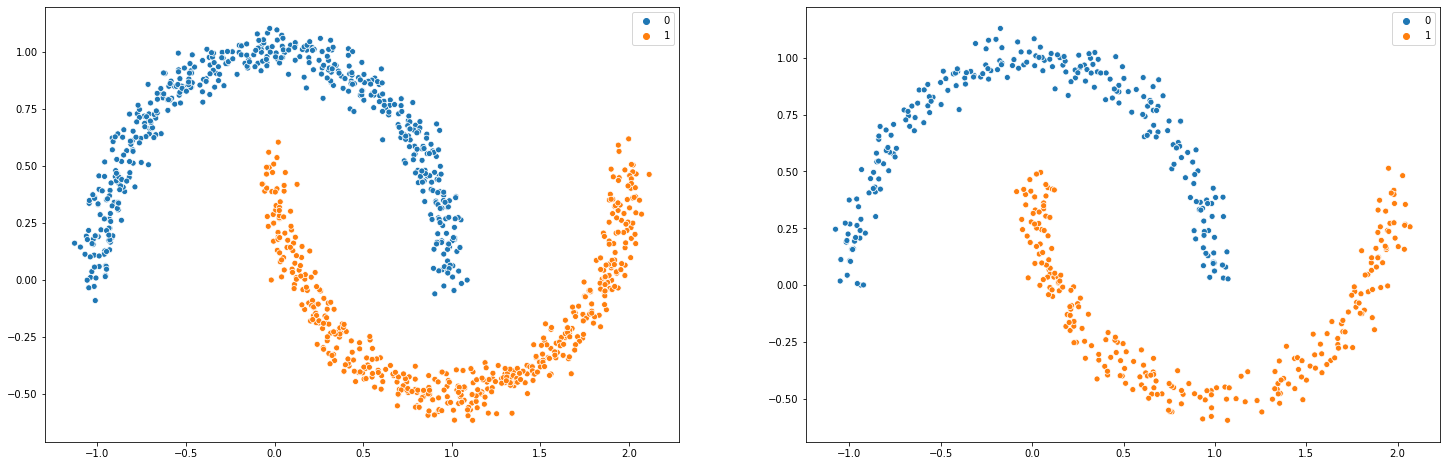

In [7]:
train_dataset, test_dataset = get_plane_dataset('moons')
f, axs = plt.subplots(1, 2, figsize = (25, 8))
for dataset, ax in zip([train_dataset, test_dataset], axs):
    sns.scatterplot(dataset.X[:, 0], dataset.X[:, 1], dataset.y.ravel(), ax = ax)

**Важно** о параметрах:  
1) На сколько я понимаю *distill_epochs* использует одни и те же данные каждую эпоху, и изменяет только *lr*, это видимо нужно для того чтобы подольше пообучать итоговую сеть на них

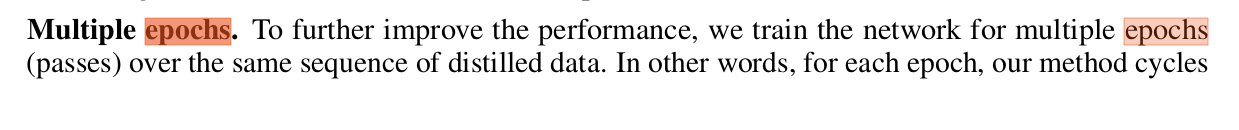

2) То на сколько хорошо обучаемыми получатся точки зависит от числа эпох *epochs*

In [183]:
# see base options.py
# class MyState():
#     def __init__(self):
#         self._mitya_dict = {}
    
#     def __getitem__(self, key):
#         return self._mitya_dict[key]
class MyState(dict):
    def __init__(self, *args, **kwargs):
        super(MyState, self).__init__(*args, **kwargs)
        self.__dict__ = self

# state = MyState()
state = MyState( **{
    'distill_steps': 1,
    'distill_epochs': 1,
    'num_classes': 2,
    'distilled_images_per_class_per_step': 4,
    'distill_lr': 0.02,
    'lr': 0.01,
    'device': torch.device('cpu'),
    'input_size': dataset.X.shape[1],
    'distributed': False,
    'decay_epochs': 1,
    'decay_factor': 1.,
    'num_workers': 8,
    'batch_size': 64,
    'checkpoint_interval': 10,
    'epochs': 400,
    'output_flag': False,
    'test_nets_type': 'unknown_init',
    'arch': 'MyMoreNonLinearNet',
    'init': 'xavier',
    'init_param': 1,
    'mode': 'distill_basic',
    'test_niter': 1,
    'train_nets_type': 'unknown_init',
    'log_interval': 100,
    'L2_coef': 1e-2
})
state['train_loader'] = torch.utils.data.DataLoader(train_dataset, batch_size=state['batch_size'],
                        num_workers=state['num_workers'], pin_memory=True, shuffle=True)

state['test_loader'] = torch.utils.data.DataLoader(test_dataset, batch_size=state['batch_size'],
                        num_workers=state['num_workers'], pin_memory=True, shuffle=False)
state['models'] = get_networks(state, N = 1)
state['test_models'] = get_networks(state, N = 1)

# MyState = namedtuple('MyState',state.keys())
# state = MyState(**state)
# state.__getattribute__()
# state.get_output_flag = lambda: state.output_flag

<class 'networks.networks.MyMoreNonLinearNet'>
<class 'networks.networks.MyMoreNonLinearNet'>


In [184]:
res = torch.sigmoid(state.test_models[0](torch.tensor(train_dataset.X).float())).detach().numpy().round()
accuracy_score(train_dataset.y, res)

0.5064676616915423

In [168]:
# x, y = iter(state['train_loader']).next()
# model = state['models'][0]
# res = model(x)

In [169]:
steps = train_distilled_image.distill(state, state.models) # main 131

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:82: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Begin of epoch 0 (1 unknown_init nets):   0%|          | 0/2 [00:00<?, ?it/s]

Begin of epoch 0 (1 unknown_init nets):  50%|█████     | 1/2 [00:00<00:00,  5.41it/s]

Begin of epoch 0 (1 unknown_init nets): 100%|██████████| 2/2 [00:00<00:00, 10.43it/s]WARNING:root:Skip saving results because output_flag is False


Begin of epoch 10 (1 unknown_init nets):   0%|          | 0/2 [00:00<?, ?it/s]

Begin of epoch 10 (1 unknown_init nets):  50%|█████   

In [170]:
data, label, lr = steps[-1]

In [171]:
steps

[(tensor([[-1.5339,  1.3784],
          [-1.6250,  1.4307],
          [ 0.0560,  2.4615],
          [-1.6759,  1.3573],
          [ 1.5260, -1.3140],
          [ 2.4622, -0.8200],
          [ 1.2670, -1.4682],
          [ 2.2055, -1.2936]], requires_grad=True),
  tensor([0, 0, 0, 0, 1, 1, 1, 1]),
  tensor([0.8474]))]

In [172]:
label

tensor([0, 0, 0, 0, 1, 1, 1, 1])

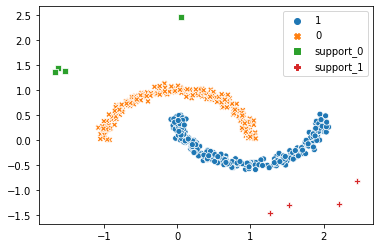

In [173]:
data, label = zip(*[(data.detach().numpy(), label.numpy()) for data, label, lr in steps])
data, label = np.concatenate(data), np.concatenate(label).tolist()
label = [f'support_{el}' for el in label]
data = np.concatenate([dataset.X, data, ])
label = np.concatenate([dataset.y.ravel(), label])
# sns.scatterplot([:, 0], dataset.X[:, 1], dataset.y.ravel())
sns.scatterplot(data[:, 0], data[:, 1], label, label)

In [197]:
steps

[(tensor([[-1.5339,  1.3784],
          [-1.6250,  1.4307],
          [ 0.0560,  2.4615],
          [-1.6759,  1.3573],
          [ 1.5260, -1.3140],
          [ 2.4622, -0.8200],
          [ 1.2670, -1.4682],
          [ 2.2055, -1.2936]], requires_grad=True),
  tensor([0, 0, 0, 0, 1, 1, 1, 1]),
  tensor([0.8474]))]

In [216]:
new_epochs = 5
lst_lr = 0.2
new_steps = [(steps[0][0], steps[0][1],\
              steps[0][2]*(1 - i/new_epochs) + lst_lr*(i/new_epochs)) for i in range(new_epochs)]

теперь нужен **evaluate_steps** из **basics**

In [217]:
results = evaluate_steps(state, new_steps,\
               f'distilled with {state.distill_steps} '+\
               f'steps and {state.distill_epochs} epochs', test_all=True)




distilled with 1 steps and 50 epochs (1 unknown_init nets):   0%|          | 0/2 [00:00<?, ?it/s]


distilled with 1 steps and 50 epochs (1 unknown_init nets):  50%|█████     | 1/2 [00:00<00:00,  3.93it/s]


distilled with 1 steps and 50 epochs (1 unknown_init nets): 100%|██████████| 2/2 [00:00<00:00,  3.90it/s]

In [218]:
test_step_indices, accuracies, losses, model_params = results

In [219]:
test_step_indices

tensor([0, 5])

In [220]:
accuracies

tensor([[0.4869],
        [0.4869]], dtype=torch.float64)

In [221]:
losses

tensor([[0.6940],
        [0.6825]], dtype=torch.float64)

In [222]:
model_params

[[tensor([ 0.1576,  0.7350,  0.3372,  0.3536,  0.8172,  0.3847,  0.5155,  0.6882,
          -0.0087, -0.0019,  0.0349,  0.0022,  0.1593,  1.2640,  0.2427,  0.3984,
           0.0698,  0.3845, -0.8311, -0.3185,  0.2007, -0.1268,  0.2064,  0.1354,
          -0.8633,  0.2228,  0.5261, -0.1818, -0.0128, -0.0381,  0.0023,  0.0681,
          -0.7685,  0.6640,  0.2830, -0.6245, -0.0285,  0.3246, -0.0095, -0.7957,
          -0.2562, -0.5381, -1.4172,  0.4438, -0.0324,  0.4595,  0.1293,  0.4843,
           0.0104, -0.0979,  0.0000,  0.0116, -0.1948,  0.4437,  0.2435,  0.3074,
          -0.0174], requires_grad=True)]]

**let's try to plot decision boundary**

In [223]:
res = torch.sigmoid(state.test_models[0](torch.tensor(test_dataset.X).float())).detach().numpy().round()
accuracy_score(test_dataset.y, res)

0.4868686868686869

In [224]:
model = state.test_models[0]
data = torch.tensor(test_dataset.X).float()
w = model_params[0][0]
ny = torch.sigmoid(model.forward_with_param(data, w)).detach().numpy().round()
accuracy_score(test_dataset.y, ny)

0.7919191919191919

/usr/lib/python3/dist-packages/ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


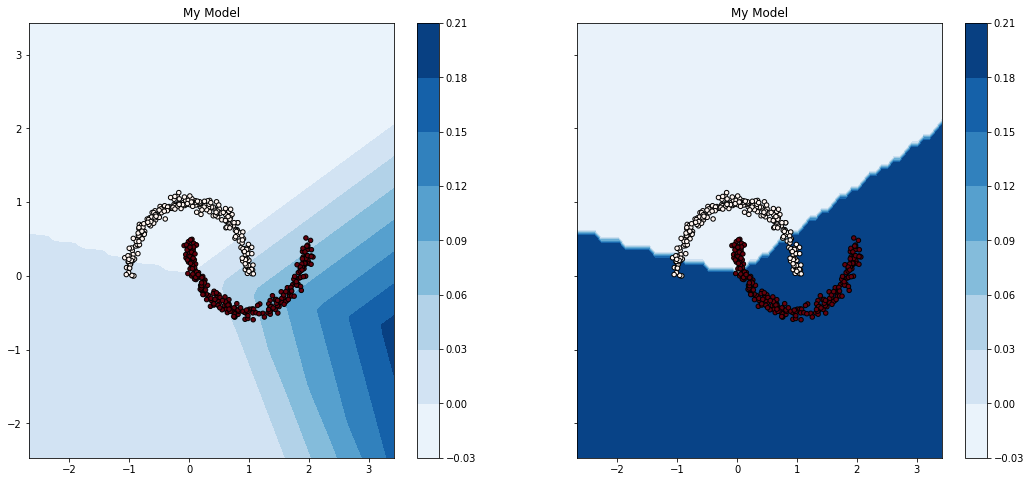

In [225]:
from itertools import product

# Loading some example data
X = test_dataset.X
y = test_dataset.y

distill_X, distill_y = steps[0][0].detach().numpy(), steps[0][1].detach().numpy()

# Trained classifiers
clf = state.test_models[0]

# Plotting decision regions
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
dx_min, dx_max = distill_X[:, 0].min() - 1, distill_X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
dy_min, dy_max = distill_X[:, 1].min() - 1, distill_X[:, 1].max() + 1
x_min, x_max = min(x_min, dx_min), max(x_max, dx_max)
y_min, y_max = min(y_min, dy_min), max(y_max, dy_max)
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, [ax1, ax2] = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(18, 8))
tt = 'My Model'

Z_data = (torch.tensor(np.c_[xx.ravel(), yy.ravel()]).float())
Zt = model.forward_with_param(Z_data, w)

# logits нужен colormap!
Z = Zt.detach().numpy().reshape(xx.shape)

c = ax1.contourf(xx, yy, Z, cmap = 'Blues')
plt.colorbar(c, ax = ax1)
ax1.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k', cmap = 'Reds')
ax1.set_title(tt)

# classes
Z = torch.sigmoid(Zt).detach().numpy().round()
Z = Z.reshape(xx.shape)
с = ax2.contourf(xx, yy, Z, cmap = 'Blues')
plt.colorbar(c, ax = ax2)
ax2.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k', cmap = 'Reds')
ax2.set_title(tt)
# plt.colorbar(ax2)

plt.show()